## Seminar 5

Today we'll start by reproducing the DQN and then try improving it with the tricks we learned on the lecture:
* Target networks
* Double q-learning
* Prioritized experience replay
* Dueling DQN
* Bootstrap DQN

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed

import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

# Processing game image (2 pts)

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape
* Converting to grayscale
* Cropping irrelevant image parts

In [3]:
from gym.core import ObservationWrapper
from gym.spaces import Box

from scipy.misc import imresize

class PreprocessBreakout(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _observation(self, img):
        """what happens to each observation"""
        
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size 
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = imresize(img[20:-10, 8:-8], (64, 64))
        return img.astype("float32").mean(axis=2) / 255


In [4]:
from lasagne import layers, objectives, regularization, updates
from lasagne.updates import adam
import theano.tensor as T
import theano
import time
import lasagne
import lasagne.layers
from lasagne.layers import dnn

[2017-03-26 18:42:31,059] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [5]:
import gym
def make_env():
    env = gym.make("BreakoutDeterministic-v0") #create raw env
    return PreprocessBreakout(env) #apply your wrapper

#spawn game instance for tests
env = make_env()

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

[2017-03-26 18:42:35,287] Making new env: BreakoutDeterministic-v0


In [6]:
obs.shape, observation_shape

((64, 64), (64, 64))

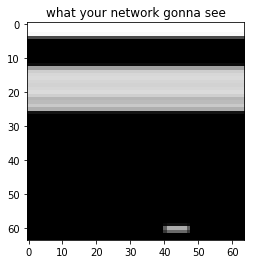

In [7]:
#test observation
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs))>2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

# print "Formal tests seem fine. Here's an example of what you'll get."

plt.title("what your network gonna see")
plt.imshow(obs,interpolation='none',cmap='gray');



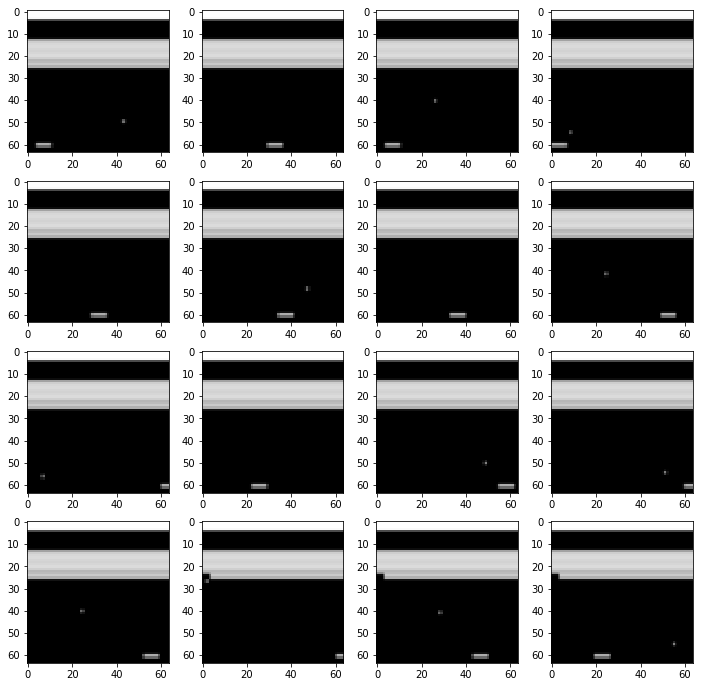

In [8]:
plt.figure(figsize=[12,12])
env.reset()
for i in range(16):
    for _ in range(10):
        new_obs = env.step(env.action_space.sample())[0]
    plt.subplot(4,4,i+1)
    plt.imshow(new_obs,interpolation='none',cmap='gray');




In [9]:
#dispose of the game instance
del env

# Building a DQN (2 pts)
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [10]:
#setup theano/lasagne. Prefer GPU. Fallback to CPU (will print warning)
# %env THEANO_FLAGS=floatX=float32

# import theano, lasagne
from lasagne.layers import *
# from theano import tensor as T

In [11]:
observation_layer = InputLayer((None,) + observation_shape)

In [12]:
#4-tick window over images
from agentnet.memory import WindowAugmentation

prev_wnd = InputLayer((None,4)+observation_shape) #window size [batch,4,64,64]

new_wnd = WindowAugmentation(observation_layer, prev_wnd)

assert new_wnd.output_shape == (None, 4, 64, 64) #if you changed img size, remove assert

In [13]:
from lasagne.nonlinearities import elu,tanh,softmax,rectify
from lasagne.layers import dnn

#<network body, growing from new_wnd. several conv layers or something similar would do>
nn = dnn.Conv2DDNNLayer(new_wnd, 16, 5, stride=3, nonlinearity=elu)
nn = dnn.Conv2DDNNLayer(nn, 32, 3, stride=2, nonlinearity=elu)
# dense = <final dense layer with 256 neurons>
dense = DenseLayer(nn, 256, nonlinearity=elu)

In [14]:
nn.output_shape

(None, 32, 9, 9)

In [15]:
#qvalues layer
qvalues_layer = DenseLayer(dense, n_actions, nonlinearity=None)#<a dense layer that predicts q-values>

assert qvalues_layer.nonlinearity is not rectify

In [16]:
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


### Define agent
Here you will need to declare how your agent works

* `observation_layers` and `action_layers` are the input and output of agent in MDP.
* `policy_estimators` must contain whatever you need for training
 * In our case, that's `qvalues_layer`, but you'll need to add more when implementing target network.
* agent_states contains our frame buffer. 
 * The code `{new_wnd:prev_wnd}` reads as "`new_wnd becomes prev_wnd next turn`"

In [17]:
from agentnet.agent import Agent
#agent
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer,
              agent_states={new_wnd:prev_wnd},)


# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [18]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent, make_env, n_games=16) #16 parallel game sessions


[2017-03-26 18:42:59,850] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:42:59,877] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:42:59,903] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:42:59,931] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:42:59,958] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:42:59,985] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:43:00,012] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:43:00,039] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:43:00,067] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:43:00,094] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:43:00,121] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:43:00,148] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:43:00,176] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:43:00,203] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:43:00,230] Making new env: BreakoutDeterministi

In [19]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(5)

print('actions:')
print(action_log[0])
print("rewards")
print(reward_log[0])

actions:
[4 4 0 0 0]
rewards
[ 0.  0.  0.  0.  0.]
CPU times: user 144 ms, sys: 12 ms, total: 156 ms
Wall time: 152 ms


In [20]:
#load first sessions (this function calls interact and remembers sessions)
SEQ_LENGTH=10 #sub-session length
pool.update(SEQ_LENGTH)

# Q-learning

We train our agent based on sessions it has played in `pool.update(SEQ_LENGTH)`

To do so, we first obtain sequences of observations, rewards, actions, q-values, etc.

Actions and rewards have shape `[n_games,seq_length]`, q-values are `[n_games,seq_length,n_actions]`

In [21]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay

actions,rewards,is_alive = replay.actions[0],replay.rewards,replay.is_alive

_,_,_,_,qvalues = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)

assert actions.ndim == rewards.ndim == is_alive.ndim == 2, "actions, rewards and is_alive must have shape [batch,time]"
assert qvalues.ndim == 3, "q-values must have shape [batch,time,n_actions]"


In [22]:
qvalues.eval().shape

(16, 10, 6)

In [23]:
#compute V(s) as Qvalues of best actions. 
#For homework assignment, you will need to use target net 
#or special double q-learning objective here

state_values_target = qvalues.max(axis=2) #* (1 - eps) + eps * qvalues.mean(axis=2)
assert state_values_target.eval().shape == qvalues.eval().shape[:2]

In [24]:
from agentnet.learning.generic import get_n_step_value_reference

# get reference Q-values via Q-learning algorithm
reference_qvalues = get_n_step_value_reference(
    state_values=state_values_target,
    rewards=rewards,
    is_alive=is_alive,
    n_steps=1,
    gamma_or_gammas=0.99,
)

#consider it constant
from theano.gradient import disconnected_grad
reference_qvalues = disconnected_grad(reference_qvalues)

In [25]:
reference_qvalues.eval().shape

(16, 10)

In [26]:
# get predicted Q-values for committed actions by both current and target networks
from agentnet.learning.generic import get_values_for_actions
action_qvalues = get_values_for_actions(qvalues, actions)


In [27]:
action_qvalues.eval().shape

(16, 10)

In [28]:
#loss for Qlearning = 
#(Q(s,a) - (r+ gamma*r' + gamma^2*r'' + ...  +gamma^10*Q(s_{t+10},a_max)))^2

elwise_mse_loss = lasagne.objectives.squared_error(action_qvalues, reference_qvalues)

#mean over all batches and time ticks
loss = (elwise_mse_loss * is_alive).mean()

In [29]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = get_all_params(action_layer)
weights

[W, b, W, b, W, b, W, b]

In [30]:
# Compute weight updates
updates = lasagne.updates.adam(loss, weights, learning_rate=1e-3)

#compile train function
train_step = theano.function([],loss,updates=updates)

# Demo run
as usual...

In [31]:
action_layer.epsilon.set_value(0.05)
untrained_reward = np.mean(pool.evaluate(save_path="./records",
                                         record_video=True))

[2017-03-26 18:45:24,765] Making new env: BreakoutDeterministic-v0
[2017-03-26 18:45:24,795] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-26 18:45:24,809] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.32309.video000000.mp4
[2017-03-26 18:45:26,053] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 280 timesteps with reward=2.0


In [32]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [33]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}
loss,reward_per_tick,reward =0,0,0

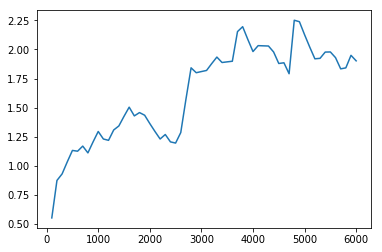

100%|██████████| 5000/5000 [32:33<00:00,  1.74it/s]


In [40]:
from tqdm import trange
from IPython.display import clear_output


for i in trange(5000):    
    
    ##update agent's epsilon (in e-greedy policy)
    current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/20000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))

    #play
    pool.update(SEQ_LENGTH)

    #train
    loss = 0.95*loss + 0.05*train_step()    
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        reward_per_tick = 0.95*reward_per_tick + 0.05*pool.experience_replay.rewards.get_value().mean()
#         print("iter=%i\tepsilon=%.3f\tloss=%.3f\treward/tick=%.3f"%(epoch_counter,
#                                                             current_epsilon, loss, reward_per_tick))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        action_layer.epsilon.set_value(0.05)
        reward = 0.95*reward + 0.05*np.mean(pool.evaluate(record_video=False))
        action_layer.epsilon.set_value(np.float32(current_epsilon))
        
        rewards[epoch_counter] = reward
        
        clear_output(True)
        plt.plot(*zip(*sorted(rewards.items(),key= lambda tr : tr[0])))
        plt.show()
        

    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

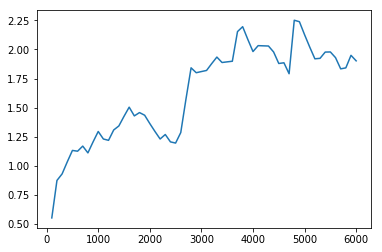

In [42]:
import pandas as pd
plt.plot(*zip(*sorted(rewards.items(),key=lambda k:k[0])))

In [43]:
from agentnet.utils.persistence import save,load
save(action_layer,"pacman.pcl")

In [50]:
action_layer.epsilon.set_value(0.05)
rw = pool.evaluate(n_games=20,save_path="./records1",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-03-26 19:46:41,107] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:46:41,135] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-26 19:46:41,149] Starting new video recorder writing to /home/ubuntu/records1/openaigym.video.64.32309.video000000.mp4
[2017-03-26 19:46:41,979] Starting new video recorder writing to /home/ubuntu/records1/openaigym.video.64.32309.video000001.mp4


Episode finished after 182 timesteps with reward=2.0
Episode finished after 251 timesteps with reward=4.0
Episode finished after 182 timesteps with reward=2.0
Episode finished after 184 timesteps with reward=2.0
Episode finished after 324 timesteps with reward=5.0
Episode finished after 231 timesteps with reward=3.0
Episode finished after 181 timesteps with reward=2.0


[2017-03-26 19:46:46,949] Starting new video recorder writing to /home/ubuntu/records1/openaigym.video.64.32309.video000008.mp4


Episode finished after 154 timesteps with reward=1.0
Episode finished after 183 timesteps with reward=2.0
Episode finished after 214 timesteps with reward=3.0
Episode finished after 215 timesteps with reward=3.0
Episode finished after 268 timesteps with reward=3.0
Episode finished after 183 timesteps with reward=2.0
Episode finished after 124 timesteps with reward=0.0
Episode finished after 181 timesteps with reward=2.0
Episode finished after 271 timesteps with reward=4.0
Episode finished after 150 timesteps with reward=1.0
Episode finished after 150 timesteps with reward=1.0
Episode finished after 124 timesteps with reward=0.0


[2017-03-26 19:46:54,022] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records1')


Episode finished after 154 timesteps with reward=1.0
mean session score=2.150000.5


In [51]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records1/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

## Assignment part 1 (2 pts)

We'll start by implementing target network to stabilize training.

There are two ways to do so: 


__1)__ Manually write lasagne network, or clone it via [one of those methods](https://github.com/Lasagne/Lasagne/issues/720).

You will need to implement loading weights from original network to target network.

We recommend thoroughly debugging your code on simple tests before applying it to Breakout.

__2)__ Use pre-build functionality from [here](http://agentnet.readthedocs.io/en/master/modules/target_network.html)

```
from agentnet.target_network import TargetNetwork
target_net = TargetNetwork(qvalues_layer)
old_qvalues = target_net.output_layers

#agent's policy_estimators must now become (qvalues,old_qvalues)

_,_,_,_,(qvalues,old_qvalues) = agent.get_sessions(...) #replaying experience


target_net.load_weights()#loads weights, so target network is now exactly same as main network

target_net.load_weights(0.01)# w_target = 0.99*w_target + 0.01*w_new
```

In [52]:
observation_layer = InputLayer((None,) + observation_shape)

prev_wnd = InputLayer((None,4)+observation_shape) #window size [batch,4,64,64]
new_wnd = WindowAugmentation(observation_layer, prev_wnd)

nn = dnn.Conv2DDNNLayer(new_wnd, 16, 5, stride=3, nonlinearity=elu)
nn = dnn.Conv2DDNNLayer(nn, 32, 3, stride=2, nonlinearity=elu)
dense = DenseLayer(nn, 256, nonlinearity=elu)

qvalues_layer = DenseLayer(dense, n_actions, nonlinearity=None)

action_layer = EpsilonGreedyResolver(qvalues_layer)

In [53]:
from agentnet.target_network import TargetNetwork

target_net = TargetNetwork(qvalues_layer)
qvalues_old = target_net.output_layers

In [54]:
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)

pool = EnvPool(agent, make_env, n_games=16)
# replay = pool.experience_replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

[2017-03-26 19:48:06,151] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,178] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,205] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,231] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,258] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,284] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,311] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,338] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,365] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,392] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,418] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,446] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,472] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,499] Making new env: BreakoutDeterministic-v0
[2017-03-26 19:48:06,526] Making new env: BreakoutDeterministi

In [55]:
_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)


actions,rewards,is_alive = replay.actions[0],replay.rewards,replay.is_alive
state_values_target = qvalues.max(axis=2)


In [56]:
reference_qvalues = get_n_step_value_reference(
    state_values=state_values_target,
    rewards=rewards,
    is_alive=is_alive,
    n_steps=1,
    gamma_or_gammas=0.99,
)

reference_qvalues = disconnected_grad(reference_qvalues)
action_qvalues = get_values_for_actions(qvalues, actions)

In [60]:
from agentnet.learning import qlearning

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      actions, #replay.actions[0],
                                                      rewards, #replay.rewards,
                                                      is_alive, #replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

# elwise_mse_loss = lasagne.objectives.squared_error(action_qvalues, reference_qvalues)
# loss = (elwise_mse_loss * is_alive).mean()

loss = elwise_mse_loss.sum() / is_alive.sum()

weights = lasagne.layers.get_all_params(action_layer,trainable=True)
# weights = get_all_params(action_layer)
updates = lasagne.updates.adam(loss, weights, learning_rate=1e-4)

#compile train function
train_step = theano.function([],loss,updates=updates)

In [64]:


#starting epoch
epoch_counter = 1

rewards = {}
loss,reward_per_tick,reward =0,0,0

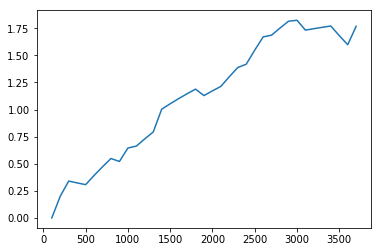

 75%|███████▍  | 3731/5000 [31:37<10:32,  2.01it/s]

KeyboardInterrupt: 

In [66]:
from tqdm import trange
from IPython.display import clear_output


for i in trange(5000):    
    
    ##update agent's epsilon (in e-greedy policy)
    current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/20000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))

    #play
    pool.update(SEQ_LENGTH)

    #train
    loss = 0.95*loss + 0.05*train_step()   
    
    target_net.load_weights(0.01)
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        reward_per_tick = 0.95*reward_per_tick + 0.05*pool.experience_replay.rewards.get_value().mean()
#         print("iter=%i\tepsilon=%.3f\tloss=%.3f\treward/tick=%.3f"%(epoch_counter,
#                                                             current_epsilon, loss, reward_per_tick))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        action_layer.epsilon.set_value(0.05)
        reward = 0.95*reward + 0.05*np.mean(pool.evaluate(record_video=False))
        action_layer.epsilon.set_value(np.float32(current_epsilon))
        
        rewards[epoch_counter] = reward
        
        clear_output(True)
        plt.plot(*zip(*sorted(rewards.items(),key= lambda tr : tr[0])))
        plt.show()
        

    
    epoch_counter  +=1

    
# Time to drink some coffee!

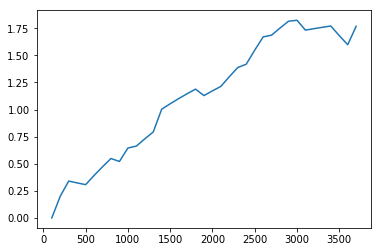

In [67]:
import pandas as pd
plt.plot(*zip(*sorted(rewards.items(),key=lambda k:k[0])))

In [69]:
action_layer.epsilon.set_value(0.05)
rw = pool.evaluate(n_games=20,save_path="./records3",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-03-26 20:28:43,549] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:28:43,577] Creating monitor directory ./records3
[2017-03-26 20:28:43,592] Starting new video recorder writing to /home/ubuntu/records3/openaigym.video.105.32309.video000000.mp4

[2017-03-26 20:28:45,197] Starting new video recorder writing to /home/ubuntu/records3/openaigym.video.105.32309.video000001.mp4



Episode finished after 371 timesteps with reward=2.0
Episode finished after 321 timesteps with reward=2.0
Episode finished after 260 timesteps with reward=0.0
Episode finished after 413 timesteps with reward=2.0
Episode finished after 399 timesteps with reward=2.0
Episode finished after 286 timesteps with reward=0.0
Episode finished after 343 timesteps with reward=2.0


[2017-03-26 20:28:52,334] Starting new video recorder writing to /home/ubuntu/records3/openaigym.video.105.32309.video000008.mp4



Episode finished after 160 timesteps with reward=0.0
Episode finished after 525 timesteps with reward=2.0
Episode finished after 553 timesteps with reward=3.0
Episode finished after 466 timesteps with reward=3.0
Episode finished after 461 timesteps with reward=3.0
Episode finished after 374 timesteps with reward=2.0
Episode finished after 417 timesteps with reward=3.0
Episode finished after 321 timesteps with reward=2.0
Episode finished after 421 timesteps with reward=3.0
Episode finished after 399 timesteps with reward=2.0
Episode finished after 173 timesteps with reward=0.0
Episode finished after 293 timesteps with reward=0.0


[2017-03-26 20:29:07,928] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records3')


Episode finished after 476 timesteps with reward=4.0
mean session score=1.850000.5


## Assignment part 2 (4+ pts)

Implement and train double q-learning.

This task contains of
* Implementing __double q-learning__ or __dueling q-learning__ or both (see tips below)
* Training a network till convergence
  * Full points will be awwarded if your network gets average score of >=10 (see "evaluating results")
  * Higher score = more points as usual
  * If you're running out of time, it's okay to submit a solution that hasn't converged yet and updating it when it converges. _Lateness penalty will not increase for second submission_, so submitting first one in time gets you no penalty.


#### Tips:
* Implementing __double q-learning__ shouldn't be a problem if you've already have target networks in place.
  * As one option, use `get_values_for_actions(<some q-values tensor3>,<some indices>)`.
  * You will probably need `T.argmax` to select best actions
  * Here's an original [article](https://arxiv.org/abs/1509.06461)

* __Dueling__ architecture is also quite straightforward if you have standard DQN.
  * You will need to change network architecture, namely the q-values layer
  * It must now contain two heads: V(s) and A(s,a), both dense layers
  * You should then add them up via elemwise sum layer or a [custom](http://lasagne.readthedocs.io/en/latest/user/custom_layers.html) layer.
  * Here's an [article](https://arxiv.org/pdf/1511.06581.pdf)
  
Here's a template for your convenience:

In [71]:
from lasagne.layers import *
class DuelingQvaluesLayer(MergeLayer):
    def get_output_for(self, inputs,**tags):
        V,A = inputs        
        return V + (A - A.max(axis=-1).reshape((-1, 1)) )
            
    def get_output_shape_for(self, input_shapes,**tags):
        V_shape,A_shape = input_shapes
        assert len(V_shape) == 2 and V_shape[-1] ==1, "V layer (first param) shape must be [batch,tick,1]"
        return A_shape #shape of q-values is same as predicted advantages

In [72]:
#mock-up tests
import theano.tensor as T
v_tensor = -T.arange(10).reshape((10,1))
V = InputLayer((None,1), v_tensor)

a_tensor = T.arange(30).reshape((10,3))
A = InputLayer((None,1), a_tensor)

Q = DuelingQvaluesLayer([V,A])

In [107]:
observation_layer = InputLayer((None,) + observation_shape)

prev_wnd = InputLayer((None,4)+observation_shape) #window size [batch,4,64,64]
new_wnd = WindowAugmentation(observation_layer, prev_wnd)

nn = dnn.Conv2DDNNLayer(new_wnd, 16, 5, stride=3, nonlinearity=elu)
nn_a = dnn.Conv2DDNNLayer(nn, 32, 3, stride=2, nonlinearity=elu)
dense_a = DenseLayer(nn_a, 256, nonlinearity=elu)
A = DenseLayer(dense_a, n_actions, nonlinearity=None)

nn_v = dnn.Conv2DDNNLayer(nn, 32, 3, stride=2, nonlinearity=elu)
dense_v = DenseLayer(nn_v, 64, nonlinearity=elu)
V = DenseLayer(dense_v, 1, nonlinearity=None)

qvalues_layer = DuelingQvaluesLayer([V, A], n_actions)

action_layer = EpsilonGreedyResolver(qvalues_layer)

In [108]:
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer,
              agent_states={new_wnd:prev_wnd},)

In [109]:

pool = EnvPool(agent, make_env, n_games=16)
# replay = pool.experience_replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

[2017-03-26 20:51:14,317] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,345] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,373] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,399] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,426] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,452] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,479] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,505] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,531] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,558] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,584] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,611] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,637] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,664] Making new env: BreakoutDeterministic-v0
[2017-03-26 20:51:14,690] Making new env: BreakoutDeterministi

In [110]:
actions,rewards,is_alive = replay.actions[0],replay.rewards,replay.is_alive

_,_,_,_,qvalues = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)

assert actions.ndim == rewards.ndim == is_alive.ndim == 2, "actions, rewards and is_alive must have shape [batch,time]"
assert qvalues.ndim == 3, "q-values must have shape [batch,time,n_actions]"

In [112]:
state_values_target = qvalues.max(axis=2) #* (1 - eps) + eps * qvalues.mean(axis=2)
# assert state_values_target.eval().shape == qvalues.eval().shape[:2]

In [113]:
reference_qvalues = get_n_step_value_reference(
    state_values=state_values_target,
    rewards=rewards,
    is_alive=is_alive,
    n_steps=1,
    gamma_or_gammas=0.99,
)

#consider it constant
from theano.gradient import disconnected_grad
reference_qvalues = disconnected_grad(reference_qvalues)

action_qvalues = get_values_for_actions(qvalues, actions)

In [114]:
elwise_mse_loss = lasagne.objectives.squared_error(action_qvalues, reference_qvalues)

#mean over all batches and time ticks
loss = (elwise_mse_loss * is_alive).mean()

weights = get_all_params(action_layer)

updates = lasagne.updates.adam(loss, weights, learning_rate=1e-3)

#compile train function
train_step = theano.function([],loss,updates=updates)

In [115]:
epoch_counter = 1

#full game rewards
rewards = {}
loss,reward_per_tick,reward =0,0,0

In [116]:
from tqdm import trange
from IPython.display import clear_output


for i in trange(5000):    
    
    ##update agent's epsilon (in e-greedy policy)
    current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/20000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))

    #play
    pool.update(SEQ_LENGTH)

    #train
    loss = 0.95*loss + 0.05*train_step()    
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        reward_per_tick = 0.95*reward_per_tick + 0.05*pool.experience_replay.rewards.get_value().mean()
#         print("iter=%i\tepsilon=%.3f\tloss=%.3f\treward/tick=%.3f"%(epoch_counter,
#                                                             current_epsilon, loss, reward_per_tick))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        action_layer.epsilon.set_value(0.05)
        reward = 0.95*reward + 0.05*np.mean(pool.evaluate(record_video=False))
        action_layer.epsilon.set_value(np.float32(current_epsilon))
        
        rewards[epoch_counter] = reward
        
        clear_output(True)
        plt.plot(*zip(*sorted(rewards.items(),key= lambda tr : tr[0])))
        plt.show()
        

    
    epoch_counter  +=1

    
# Time to drink some coffee!


  0%|          | 0/5000 [00:00<?, ?it/s]


ValueError: dimension mismatch in args to gemm (16,64)x(64,1)->(16,6)
Apply node that caused the error: GpuGemm{inplace}(GpuElemwise{Add}[(0, 0)].0, TensorConstant{1.0}, GpuElemwise{Composite{Switch(i0, i1, expm1(i1))}}[(0, 0)].0, W, TensorConstant{1.0})
Toposort index: 98
Inputs types: [CudaNdarrayType(float32, matrix), TensorType(float32, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), TensorType(float32, scalar)]
Inputs shapes: [(16, 6), (), (16, 64), (64, 1), ()]
Inputs strides: [(6, 1), (), (64, 1), (1, 0), ()]
Inputs values: ['not shown', array(1.0, dtype=float32), 'not shown', 'not shown', array(1.0, dtype=float32)]
Outputs clients: [[GpuElemwise{Add}[(0, 2)](GpuDimShuffle{x,0}.0, GpuElemwise{Neg}[(0, 0)].0, GpuGemm{inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Bonus II (5+ pts): Prioritized experience replay

In this section, you're invited to implement prioritized experience replay

* You will probably need to provide a custom data structure
* Once pool.update is called, collect the pool.experience_replay.observations, actions, rewards and is_alive and store them in your data structure
* You can now sample such transitions in proportion to the error (see [article](https://arxiv.org/abs/1511.05952)) for training.

It's probably more convenient to explicitly declare inputs for "sample observations", "sample actions" and so on to plug them into q-learning.

Prioritized (and even normal) experience replay should greatly improve amount of breakout games you need to play in order to achieve good performance. 

While it's effect on runtime is limited for atari, more complicated envs (further in the course) will certainly benefit for it.

Prioritized experience replay only supports off-policy algorithms, so pls enforce `n_steps=1` in your q-learning reference computation (default is 10).